In [2]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [125]:
using DifferentialEquations, PhasorNetworks, Lux, NNlib, Zygote, ComponentArrays, Optimisers, OneHotArrays, JLD2
using Plots, QuadGK
using MLUtils: DataLoader
using Random: Xoshiro
using ChainRulesCore: ignore_derivatives
using Statistics: mean

In [17]:
using ChainRulesCore: ignore_derivatives

In [18]:
using Base: @kwdef

# Load the dataset

In [19]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [20]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [8]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [9]:
data_dir = "pixel_data/"

"pixel_data/"

In [10]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [11]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [12]:
ylimits = extrema(ylocal) .* 2.0

(-16.1073, 16.3671)

In [13]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [14]:
q |> size

(20, 13, 21, 99991)

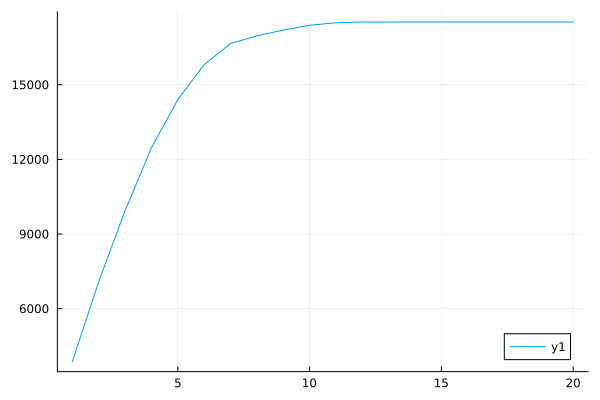

In [21]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

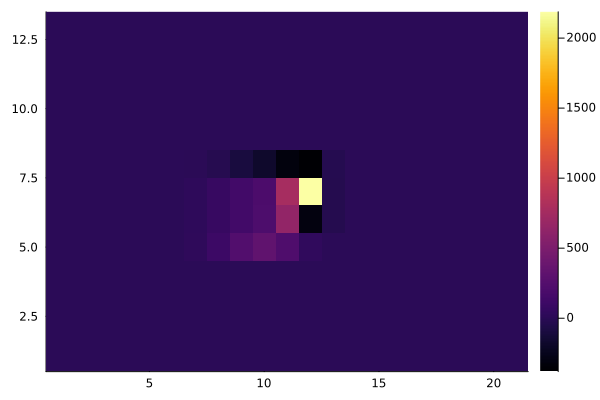

In [22]:
heatmap(q[1,:,:,128])

In [23]:
ylocal |> size

(99991,)

In [24]:
pt |> size

(99991,)

In [25]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [26]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [27]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [28]:
#dimensions - (t, y, x, b): (time, y, x, batch)

In [29]:
x |> size

(20, 13, 21, 128)

In [30]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [31]:
function process_inputs(x::AbstractArray, x_tms::AbstractVector, y_local::AbstractArray, spk_args::SpikingArgs)
    v_fn = t -> sum(scale_charge(interpolate_2D(t, x_tms, x)), dims=2)[:,1,:]
    y_fn = t -> ylocal_to_current(t, y_local, spk_args)

    x_fn = t -> cat(v_fn(t), reshape(y_fn(t), (1,:)), dims=1)
    return x_fn
end

process_inputs (generic function with 1 method)

In [32]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [33]:
x_tms = range(start=0.0, stop=1.0, length=size(x, 1)) |> collect

20-element Vector{Float64}:
 0.0
 0.05263157894736842
 0.10526315789473684
 0.15789473684210525
 0.21052631578947367
 0.2631578947368421
 0.3157894736842105
 0.3684210526315789
 0.42105263157894735
 0.47368421052631576
 0.5263157894736842
 0.5789473684210527
 0.631578947368421
 0.6842105263157895
 0.7368421052631579
 0.7894736842105263
 0.8421052631578947
 0.8947368421052632
 0.9473684210526315
 1.0

In [34]:
i_fn = process_inputs(x, x_tms, xl, sa)

#71 (generic function with 1 method)

In [35]:
function sample_current(t, x, i_fn)
    i = sum(i_fn(t), dims=(2))
    i = i[:,1,:]

end

sample_current (generic function with 1 method)

In [36]:
sample_current(0.5, x, i_fn)

14×1 Matrix{Float64}:
   0.0
   0.9312
  12.72694
  83.212
 240.36753999999993
 304.9427600000001
 254.99722000000003
  75.04914
  10.44664
  -0.008279999999999994
   0.0
   0.0
   0.0
  21.045959887366465

In [37]:
ode_fn = Chain(BatchNorm(n_in),
                    x -> tanh.(x),
                    Dense(n_in => 128))

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction(#75),
    layer_3 = Dense(14 => 128),         # 1_920 parameters
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [38]:
ode_model = Chain(PhasorODE(ode_fn, tspan=(0.0, 1.0), dt=0.01),
x -> complex_to_angle(Array(x)[:,:,end]),
PhasorDenseF32(128 => 3))

Chain(
    layer_1 = PhasorODE(
        model = Chain(
            layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
            layer_2 = WrappedFunction(#75),
            layer_3 = Dense(14 => 128),  # 1_920 parameters
        ),
    ),
    layer_2 = WrappedFunction(#77),
    layer_3 = PhasorDenseF32((3, 128)),  # 390 parameters
)         # Total: 2_338 parameters,
          #        plus 29 states.

In [39]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, ode_model)

((layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0])), (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()),

In [40]:
y_naive, _ = ode_model(i_fn, ps, st);

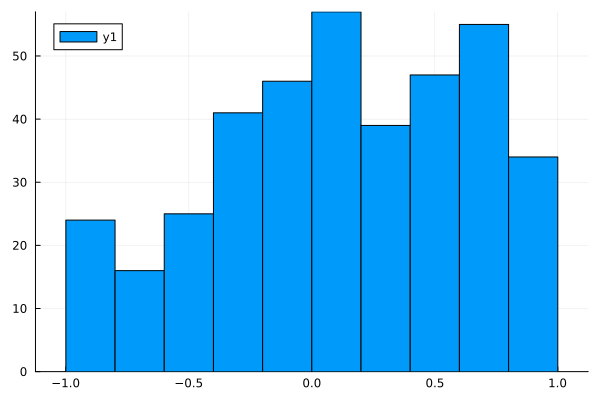

In [41]:
histogram(y_naive |> vec)

In [42]:
psa = ComponentArray(ps)

ComponentVector{Float32}(layer_1 = (layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.018712677 0.1624646 … 0.007739915 -0.16842416; -0.13419782 0.1107008 … 0.11776306 -0.17111422; … ; 0.14632118 -0.18586333 … -0.14887094 -0.09080278; 0.081494965 -0.12686923 … 0.11615222 -0.1931912], bias = Float32[0.0; 0.0; … ; 0.0; 0.0;;])), layer_2 = Float32[], layer_3 = (weight = Float32[-0.6364781 -0.1468213 … -0.45209214 -1.2981989; 0.13197331 -0.15271217 … -0.90644777 1.1886011; 0.22037269 1.2447073 … 0.24299388 0.055335063], bias_real = Float32[1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0]))

In [43]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [44]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [45]:
function loss(x, x_tms, xl, y, model, ps, st, threshold, spk_args::SpikingArgs=SpikingArgs())
    drive_fn = process_inputs(x, x_tms, xl, spk_args)
    y_pred, st = model(drive_fn, ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 2 methods)

In [46]:
loss(x, x_tms, xl, y, ode_model, psa, st, 0.2)

(0.7823017057233769, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [47]:
(loss_val, st), gs = withgradient(p -> loss(x, x_tms, xl, y, ode_model, p, st, 0.2), psa)

(val = (0.7823016784003473, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple())), grad = ((layer_1 = (layer_1 = (scale = Float32[0.011527562, -0.009585654, 9.863274f-5, -0.021618558, 0.065924674, 0.068935424, -0.014281816, -0.019750223, 5.548827f-5, -0.032373838, -0.00780892, 0.0, 0.0, -0.0755052], bias = Float32[0.094231755, 0.043128546, -0.059831996, 0.03950188, -0.033843733, -0.117351316, 0.06703642, 0.032647885, 0.09836483, 0.06474271, 0.09151063, -0.10884143, -0.26623213, -0.055274423]), layer_2 = Float32[], layer_3 = (weight = Float32[-0.0022527648 -0.0022420066 … 0.0 -0.023072165; -0.0040059933 0.00073116744 … 0.0 -0.059380375; … ; 0.007807198 0.013398728 … 0.0 0.09658991; 0.0035845097 -0.005889355 … 0.0

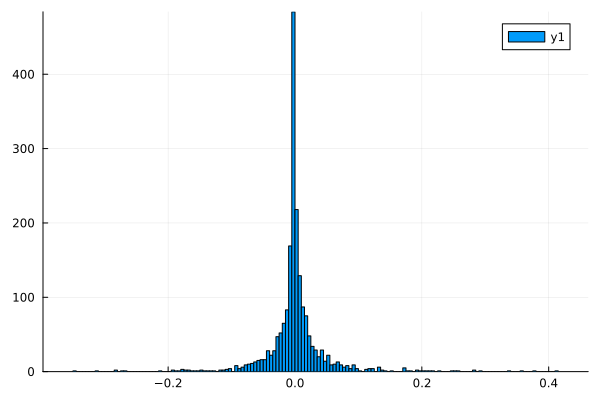

In [48]:
histogram(gs[1].layer_1 |> vec)

In [49]:
function train(model, ps, st, train_loader, x_tms, threshold::Real = 0.2; id::Int=1, kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []
    i = 0

    ## Training
    for epoch in 1:args.epochs
        print("Epoch ", epoch)
        epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, x_tms, xl, y, model, p, st, threshold), ps)
            append!(epoch_losses, loss_val)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
        end
        append!(losses, mean(epoch_losses))
        println(" mean loss ", string(mean(epoch_losses)))
        #filename = joinpath("parameters", "id_") * string(id) * "_epoch_" * string(epoch) * ".jld2"
        #jldsave(filename; params=ps, state=st)
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [50]:
#loss_history, pst, stt = train(ode_model, psa, st, train_loader, x_tms, 0.2, epochs = 1)

In [51]:
#load params

In [52]:
res = load("parameters/id_43_epoch_124.jld2")

Dict{String, Any} with 2 entries:
  "params" => (layer_1 = (layer_1 = (scale = Float32[0.431862, 0.569591, 1.2014…
  "state"  => (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0,…

In [95]:
pst = res["params"]
stt = res["state"]

(layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [99]:
loss(x, x_tms, xl, y, ode_model, pst, stt, 0.2)

(0.1506724951548314, (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [65]:
function call_model(model, x, x_tms, xl, ps, st)
    drive_fn = process_inputs(x, x_tms, xl, sa)
    y_pred, _ = model(drive_fn, ps, st)
    return y_pred
end

call_model (generic function with 1 method)

In [85]:
call_fn = (a, b) -> call_model(ode_model, a, x_tms, b, pst, stt)

#94 (generic function with 1 method)

In [75]:
yt, _ = ode_model(process_inputs(x, x_tms, xl, sa), pst, stt)

(Float32[0.008145854 0.014509909 … 0.009244251 0.014743901; 0.46995488 0.23492496 … 0.13110758 0.26335707; 0.11605285 0.20845619 … 0.4427615 0.18525572], (layer_1 = (layer_1 = (running_mean = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], running_var = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple()), layer_2 = NamedTuple(), layer_3 = NamedTuple()))

In [101]:
yt = call_fn(x, xl)

3×128 Matrix{Float32}:
 0.00814585  0.0145099  0.00412802  …  0.0285836  0.00924425  0.0147439
 0.469955    0.234925   0.208646       0.0707306  0.131108    0.263357
 0.116053    0.208456   0.253055       0.43102    0.442762    0.185256

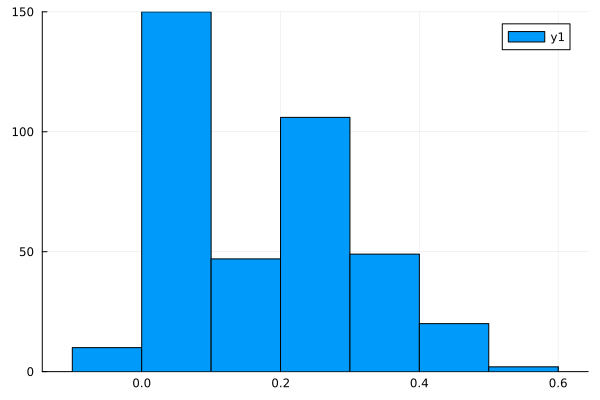

In [102]:
histogram(yt |> vec)

# Calculate the Test Loss

In [103]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [108]:
function accuracy(x, xl, y, model_call::Function, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred = model_call(x, xl)
    y_labels = onecold(y_pred, (0, 1, 2))
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 2 methods)

In [ ]:
accuracy(xts, xlts, yts, call_fn, 0.2)

85

In [127]:
@time yth = call_fn(q_test[:,:,:,1:10000], ylocal_test[1:10000])

423.714592 seconds (98.05 k allocations: 173.724 GiB, 75.13% gc time, 0.01% compilation time)


3×10000 Matrix{Float32}:
  0.00575107  0.0132568  0.0183644  …  0.0170798   0.0171345   0.0173739
 -0.0206989   0.122195   0.492961      0.0521639  -0.00448545  0.33241
  0.476591    0.385603   0.113538      0.376457    0.470852    0.177874

In [128]:
function accuracy_compare(y_pred, y, threshold::Real)
    y_labels = onecold(y_pred, (0, 1, 2))
    y_truth = get_truth(y, threshold)
    right = sum(y_truth .== y_labels)
    return right
end

accuracy_compare (generic function with 1 method)

In [130]:
accuracy_compare(yth, pt_test[1:10000], 0.2)

7148

In [111]:
function confusion_matrix(prediction, truth, threshold::Real)
    truth = hcat(truth .== 1, truth .== 0)
    prediction = hcat(prediction .> threshold, prediction .<= threshold)

    confusion = truth' * prediction
    return confusion
end

confusion_matrix (generic function with 1 method)

In [112]:
using LinearAlgebra: diag

In [131]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [132]:
roc_fn = interpolate_roc(roc)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    203-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


203-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [133]:
roc_xs = 0.0:0.01:1.0

0.0:0.01:1.0

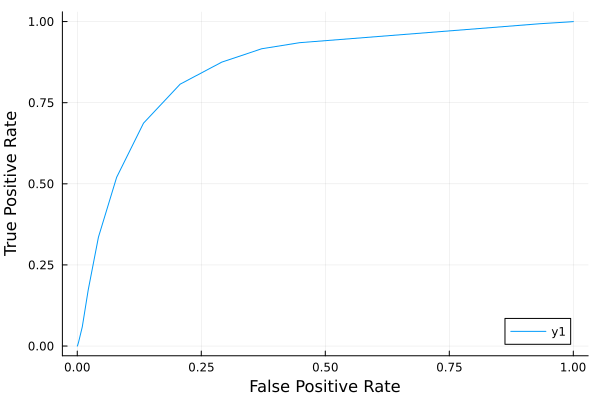

In [134]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

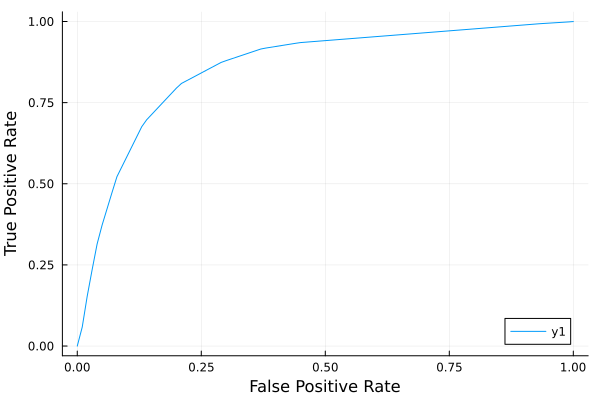

In [135]:
plot(roc_xs, roc_fn.(roc_xs))
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [136]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8579861104555654, 1.123425010496124e-8)